# Multivariate LSTM Modelling

In this notebook, we will use PyTorch to construct a multivariate LSTM model to forecast the daily adjusted close price of NVIDIA stock

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from Functions import tsPlot
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

### Enable GPU

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

### Import Data

Now we load in the time series data for and cut it down to a 5 year period for 2018 to 2023 and store it in the dataframe called 'df_ret' and 'df_exog'

In [3]:
# Read the csv file into a pandas DataFrame
df_ret = pd.read_csv('../DataManagement/daily_data.csv', parse_dates=['DATE'], index_col='DATE')

# Specify the date range
start_date = '2018-06-30'
end_date = '2023-06-30'

# Slice the DataFrame for the desired date range
df_ret = df_ret.loc[start_date:end_date].copy()

## Plots

As usual, we qucikly plot the time series to make sure that looks as we expect

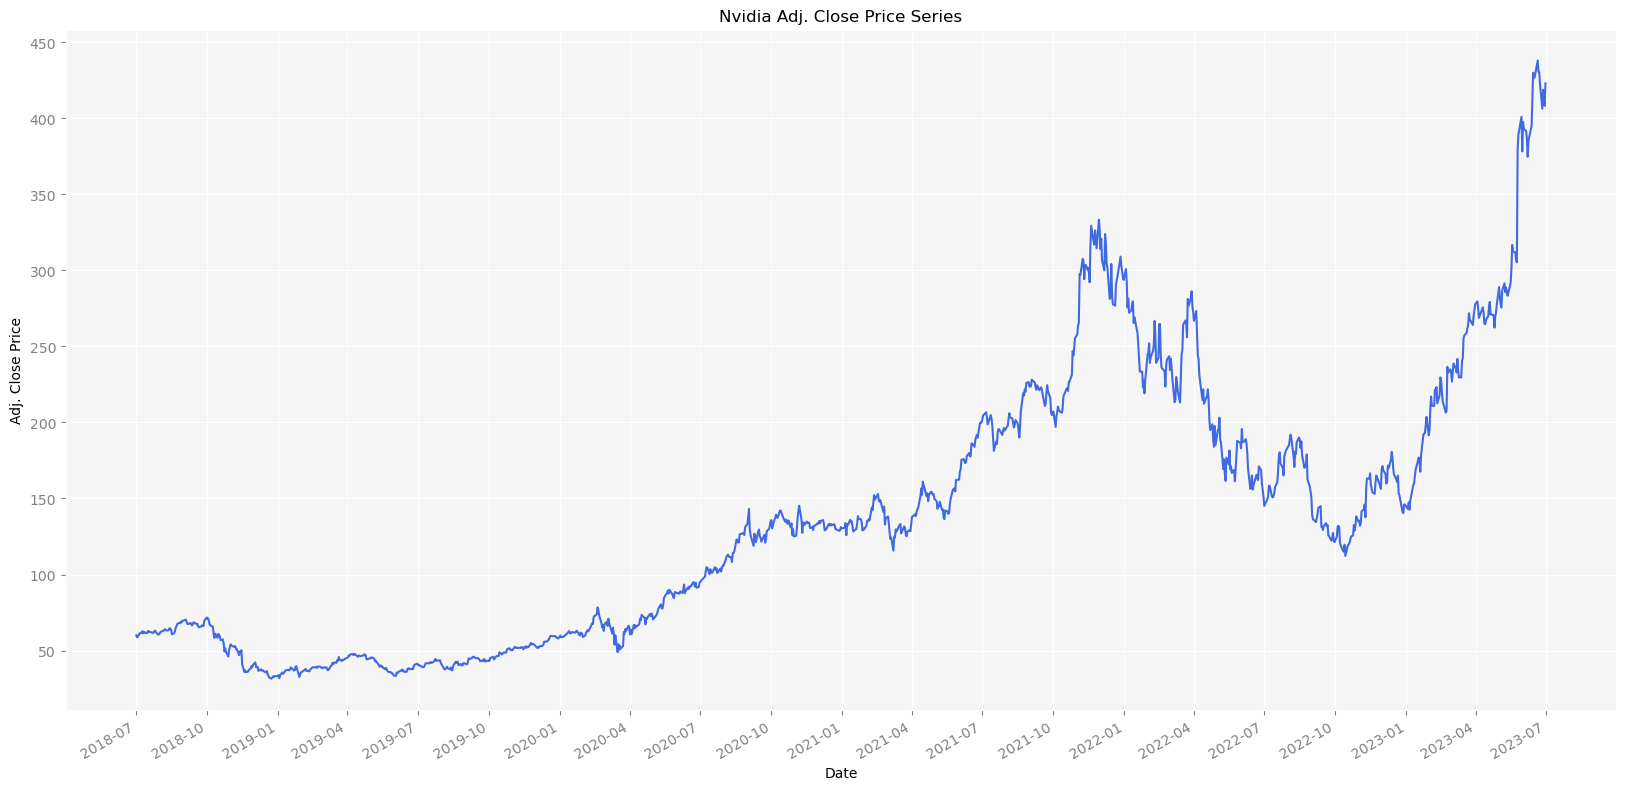

In [4]:
tsPlot(df_ret['NVDA_CLOSE'], "Nvidia", "Adj. Close Price")

## Data Pre-Processing

### Create Sequences

Here we define a function that transforms the data into the format requred by the LSTM with parameters for lookback period.

In [6]:
def prepare_data_lstm(data, n_steps, column):
    column_names = [column]
    data = dc(data)  # make deep copy of the input data

    for i in range(1, n_steps+1):
        column_name = f'{column}(t-{i})'
        column_names.append(column_name)
        data[column_name] = data[column].shift(i)

    data.dropna(inplace=True)
    data = data.loc[:, data.columns.intersection(column_names)]

    return data

Now, since we are working with multivariate data, we need to be careful to make sure that our X matrix follows the structure laid out in the diagram found in the README file. We will effectively call the prepare_data_lstm function on each feature seperaterly to generate the sequences and then perform some transformations afterwards to combine the data into a single X matrix as needed.

In [7]:
lookback = 7

# Same as the univariate case
shifted_close = prepare_data_lstm(df_ret, lookback, 'NVDA_CLOSE')    

# New: now we also perform the same procedure on each of the additional features that we wish to include in our X matrix
shifted_open = prepare_data_lstm(df_ret, lookback, 'NVDA_OPEN')
shifted_high = prepare_data_lstm(df_ret, lookback, 'NVDA_HIGH')
shifted_low = prepare_data_lstm(df_ret, lookback, 'NVDA_LOW')
shifted_volume = prepare_data_lstm(df_ret, lookback, 'NVDA_VOLUME')

# Now we convert the dataframes into numpy matrices
shifted_close_np = shifted_close.to_numpy()
shifted_open_np = shifted_open.to_numpy()
shifted_high_np = shifted_high.to_numpy()
shifted_low_np = shifted_low.to_numpy()
shifted_volume_np = shifted_volume.to_numpy()

Now we perform standardisation on the dataset. We have to be careful here because some variables are recorded on very different scales, for example, volume figures are magnitudes larger than open, high, low and close figures. As a result, we will scale volume seperately to the other variables so that we do not introduce bias into the dataset.

In [9]:
# Scaler for price data
price_scaler = MinMaxScaler(feature_range=(-1,1))    # scale to range -1 to 1

# Scaler for volume data
volume_scaler = MinMaxScaler(feature_range=(-1,1))    # scale to range -1 to 1

# Scale the price data
shifted_open_np_scaled = price_scaler.fit_transform(shifted_open_np)
shifted_high_np_scaled = price_scaler.fit_transform(shifted_high_np)
shifted_low_np_scaled = price_scaler.fit_transform(shifted_low_np)
shifted_close_np_scaled = price_scaler.fit_transform(shifted_close_np)

# Scale the volume data
shifted_volume_np_scaled = volume_scaler.fit_transform(shifted_volume_np)

Here we do a quick check to make sure the shapes of out numpy matrices match

In [14]:
print(shifted_close_np_scaled.shape, shifted_volume_np_scaled.shape)


(1251, 8) (1251, 8)


Now we split the standardised returns into our X and y vectors

In [20]:
# Our y vector does not change in the multivariate case since we are still predicting the close prices
y = shifted_close_np_scaled[:, 0]

# Our X matrix does change though as we need to add additional dimensions to store the extra variables
# We start by slicing out the time t column from each of the X components
X_open = shifted_open_np_scaled[:, 1:]
X_high = shifted_high_np_scaled[:, 1:]
X_low = shifted_low_np_scaled[:, 1:]
X_volume = shifted_volume_np_scaled[:, 1:]

# Then we individually "flip" each X component so that it goes, for example, t-7, t-6, t-5....
X_open = dc(np.flip(X_open, axis=1))
X_high = dc(np.flip(X_high, axis=1))
X_low = dc(np.flip(X_low, axis=1))
X_volume = dc(np.flip(X_volume, axis=1))

# Finally, we combine each X component into a single X matrix with the shape (samples, time steps, features) i.e. (1251, 7, 4) in this case
X = np.stack((X_open, X_high, X_low, X_volume), axis=-1)

# Also, y currently has shape (1251) but it needs to have shape (1251, 1) in this framework
y = y.reshape((-1, 1))

Here we check that the shape of y and X are as expected

In [22]:
y.shape, X.shape

((1251, 1), (1251, 7, 4))

Now perform a train/test split where the first 95% of the data is used for training and the last 5% for testing

In [23]:
split_index = int(len(X) * 0.95)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1188, 7, 4), (63, 7, 4), (1188, 1), (63, 1))

Then we convert the matrices into tensor objects

In [24]:
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

Now we define a class that we will use to turn these individual matrices into train and test datasets

In [25]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

Now we wrap our datasets in data loaders

In [26]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Send the batches to our compute device (GPU:0 in this case as we defined in the 'setup' section)

In [27]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 4]) torch.Size([16, 1])


## LSTM Model

The inputs of the below class are as follows:

* input_size : number of features
* hidden_size : dimension of hidden layers
* num_stacked_layers : number of layers because we can stack LSTM's since as we run through them, they will actually create sequences themselves

In [29]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [30]:
input_size = 4    # Important, this has to be 4 since we now have 4 features
hidden_size = 4
num_stacked_layers = 1

model = LSTM(input_size, hidden_size, num_stacked_layers)
model.to(device)
model

LSTM(
  (lstm): LSTM(4, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

Train function

In [31]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 9:  # print every 10 batches
            avg_loss_across_batches = running_loss / 10
            print('Batch {0}, Loss: {1:.6f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

Validate function

In [32]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

Train the model

In [41]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 10, Loss: 0.002649
Batch 20, Loss: 0.002261
Batch 30, Loss: 0.002542
Batch 40, Loss: 0.002901
Batch 50, Loss: 0.002683
Batch 60, Loss: 0.002322
Batch 70, Loss: 0.002377

Val Loss: 0.105
***************************************************

Epoch: 2
Batch 10, Loss: 0.001532
Batch 20, Loss: 0.002159
Batch 30, Loss: 0.001984
Batch 40, Loss: 0.001545
Batch 50, Loss: 0.001636
Batch 60, Loss: 0.001930
Batch 70, Loss: 0.001848

Val Loss: 0.091
***************************************************

Epoch: 3
Batch 10, Loss: 0.001244
Batch 20, Loss: 0.001451
Batch 30, Loss: 0.001596
Batch 40, Loss: 0.002101
Batch 50, Loss: 0.001629
Batch 60, Loss: 0.001652
Batch 70, Loss: 0.001672

Val Loss: 0.078
***************************************************

Epoch: 4
Batch 10, Loss: 0.001487
Batch 20, Loss: 0.001473
Batch 30, Loss: 0.001937
Batch 40, Loss: 0.001035
Batch 50, Loss: 0.001392
Batch 60, Loss: 0.001404
Batch 70, Loss: 0.001436

Val Loss: 0.073
*************************************

## LSTM Training Predictions

Plots the predicted vs actual data

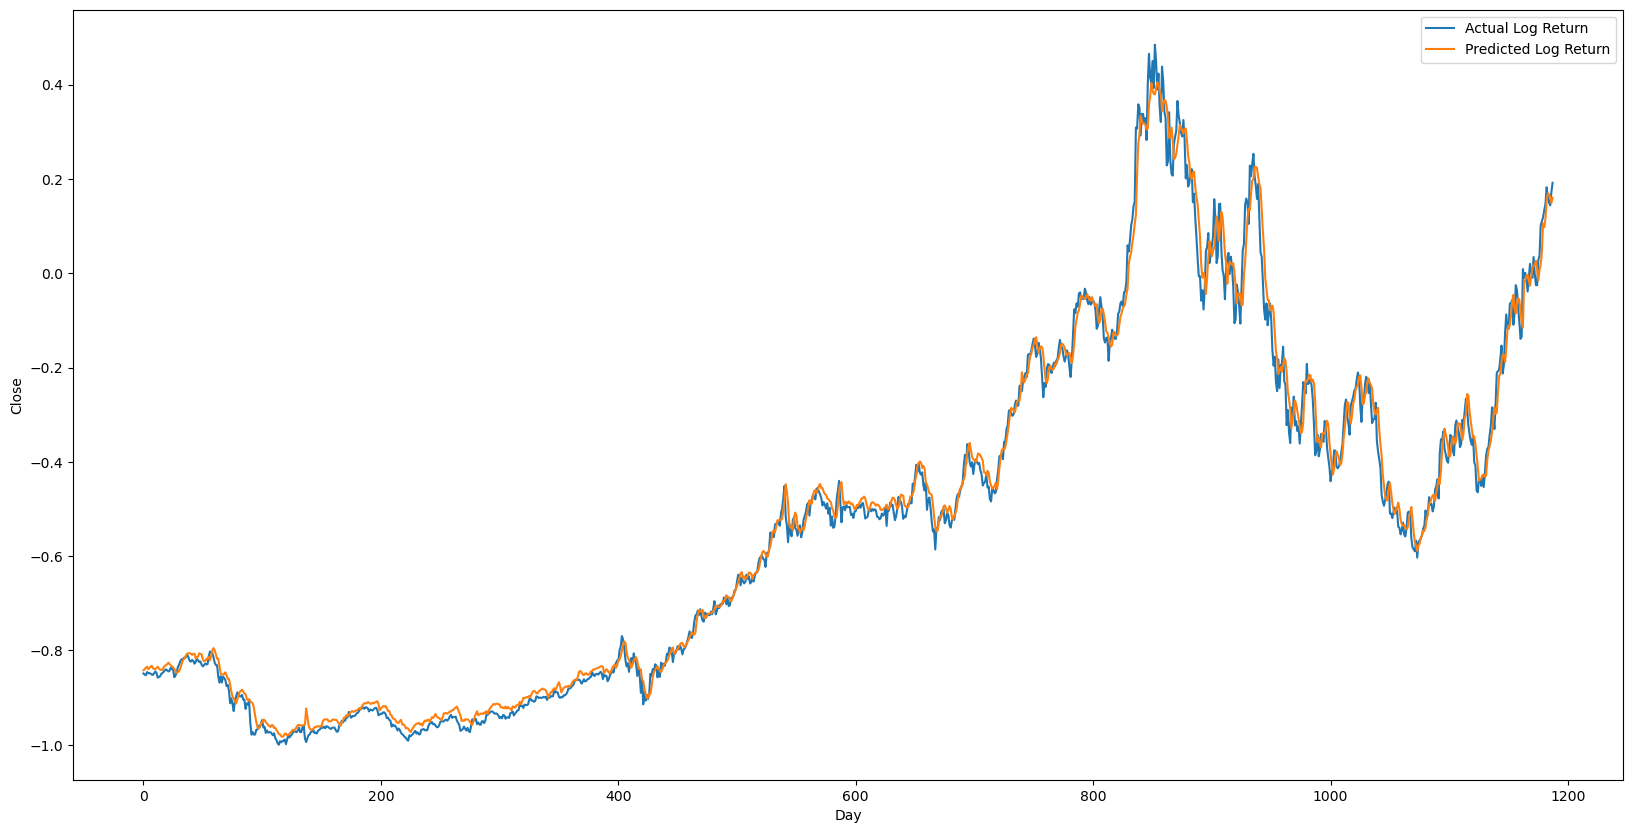

In [42]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()    # we have to move this to the cpu now because numpy cannot access the gpu

plt.figure(figsize=(20, 10))
plt.plot(y_train, label='Actual Log Return')
plt.plot(predicted, label='Predicted Log Return')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

The above data is still in the standardised form so now we perform some transformations to revert it back to the original scale

In [43]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))  # here we are basically trying to make a dummy matrix that 'looks like' the original matrix of data that we started with
dummies[:, 0] = train_predictions
dummies = price_scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 63.65288995,  64.0267709 ,  64.76926226, ..., 267.70058   ,
       265.0400314 , 267.3814884 ])

In [44]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = price_scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 62.23390404,  61.76076738,  61.48331908, ..., 264.07269411,
       269.81207198, 273.8016651 ])

Now plot the same as before but with our 'un-scaled' data

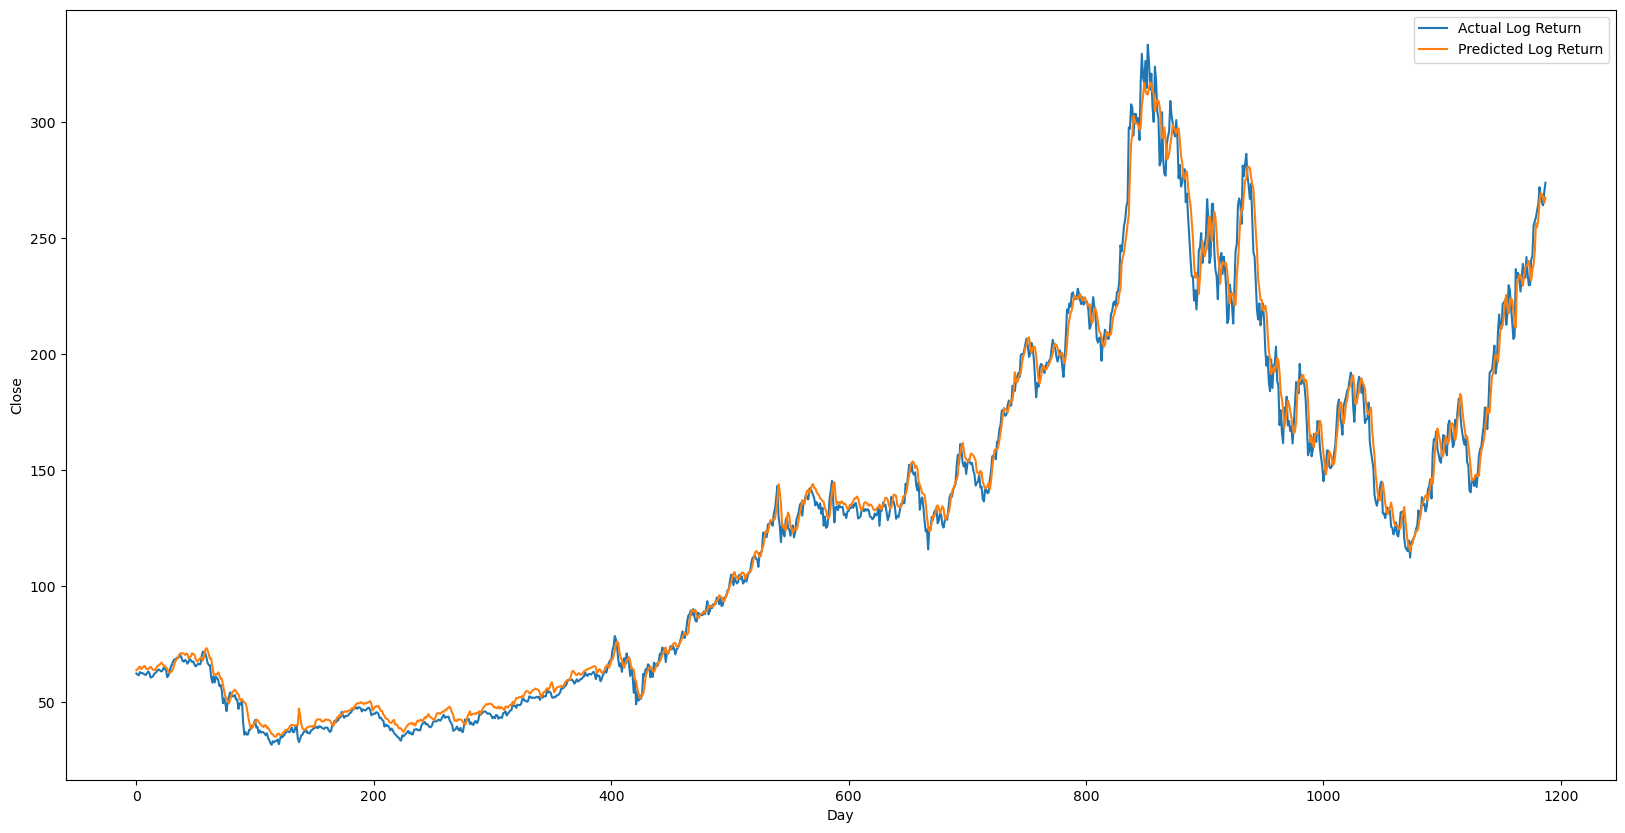

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(new_y_train, label='Actual Log Return')
plt.plot(train_predictions, label='Predicted Log Return')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

## LSTM Test Predictions

As before, we reverse the scaling on the predictions and y values

In [46]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = price_scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])

In [47]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = price_scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

Then we plot them

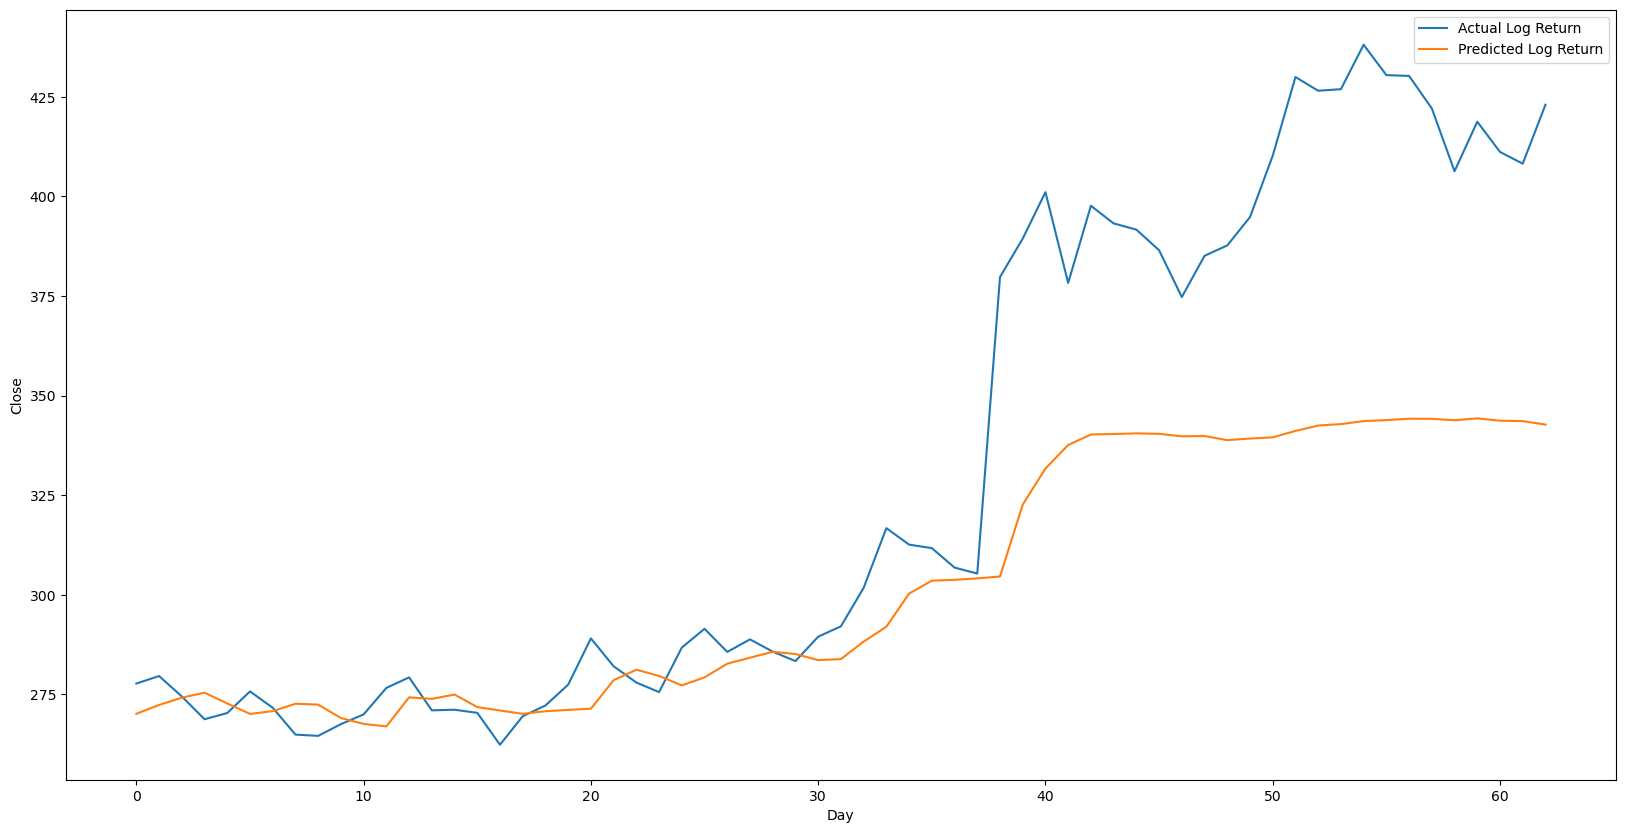

In [48]:
plt.figure(figsize=(20, 10))
plt.plot(new_y_test, label='Actual Log Return')
plt.plot(test_predictions, label='Predicted Log Return')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

## Analysis

First, an interesting statistic to look at is win rate, which simply put, is the proportion of the time that the model simply predicted the correct "direction"